In [50]:
import pandas as pd
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from pli import generate_pli, pli_intersection_optimized
from candidates import prepare_Fk, generate_candidates

Make a toy dataset to play with

In [51]:
data = {
    'a': ['C', 'A', 'A', 'B', 'C'],
    'b': [3, 1, 1, 1, 1],
    'c': ['X', 'X', 'Y', 'X', 'X'],
    'd': [722, 289, 189, 289, 289],
    'e': [112, 553, 583, 513 ,553]
}

df = pd.DataFrame(data)
df

,a,b,c,d,e
0,C,3,X,722,112
1,A,1,X,289,553
2,A,1,Y,189,583
3,B,1,X,289,513
4,C,1,X,289,553


# Candidates generation

<div>
<img src="img/candidates_generation.png" width="500"/>
</div>

In [52]:
def prepare_Fk(df):
    """
    Trasform df into the format
    Fk = [(f1, pli1), (f2, pli2), ..., (fk, plik)]
    """
    Fk = []

    for col in df.columns:
        pli = generate_pli(df[col])
        Fk.append((col, pli))

    return Fk


def generate_candidates(Fk):
    """
    Generates candidates for UCC (unique column combination) 
    discovery in Apriori algorithm.

    Input: 
    Fk is a list of non-unique candidates with its PLIs in the 
    following format: Fk = [(f1, pli1), (f2, pli2), ..., (fk, plik)]
    
    Output: 
    Candidates for the next level in the same format as Fk.
    """
    E = []

    schema = [f[0] for f in Fk]

    # traverse all pairs of non-unique column combinations 
    # (if column is unique, than all its supersets will be also unique!) 
    # that share the same maximal prefix (they are in lexicographic order) 
    # and differ only in one last attribute

    for f1, pli1 in Fk:
        for f2, pli2 in Fk:

            # use lexicographic order
            # so consider 2nd element in a pair
            # that is located on the right
            if f1 < f2:

                # check if f1 and f2 share the same maximal prefix 
                # and differ only in the last attribute
                if f1[:-1] == f2[:-1]:

                    # make new CC with k+1 attributes 
                    # using a union of f1 and f2
                    f = f1 + f2[-1]

                    # and make an intersection of PLIs
                    pli = pli_intersection_optimized(pli1, pli2)

                    # if all subsets with k attributes are non-unique
                    if all(''.join(sorted(set(f) - set(i))) in schema for i in f):
                        E.append((''.join(f), pli))             
                               
    return E

In [53]:
E1 = prepare_Fk(df)
E1

[('a', {1: [0, 4], 2: [1, 2]}),
 ('b', {2: [1, 2, 3, 4]}),
 ('c', {1: [0, 1, 3, 4]}),
 ('d', {2: [1, 3, 4]}),
 ('e', {2: [1, 4]})]

In [54]:
E2 = generate_candidates(E1)
E2

[('ab', {(2, 2): [1, 2]}),
 ('ac', {(1, 1): [0, 4]}),
 ('ad', {}),
 ('ae', {}),
 ('bc', {(2, 1): [1, 3, 4]}),
 ('bd', {(2, 2): [1, 3, 4]}),
 ('be', {(2, 2): [1, 4]}),
 ('cd', {(1, 2): [1, 3, 4]}),
 ('ce', {(1, 2): [1, 4]}),
 ('de', {(2, 2): [1, 4]})]

In [55]:
E3 = generate_candidates(E2)
E3

[('abc', {}),
 ('abd', {}),
 ('abe', {}),
 ('acd', {}),
 ('ace', {}),
 ('ade', {}),
 ('bcd', {((2, 1), (2, 2)): [1, 3, 4]}),
 ('bce', {((2, 1), (2, 2)): [1, 4]}),
 ('bde', {((2, 2), (2, 2)): [1, 4]}),
 ('cde', {((1, 2), (1, 2)): [1, 4]})]

In [56]:
E4 = generate_candidates(E3)
E4

[('abcd', {}),
 ('abce', {}),
 ('abde', {}),
 ('acde', {}),
 ('bcde', {(((2, 1), (2, 2)), ((2, 1), (2, 2))): [1, 4]})]

In [57]:
E5 = generate_candidates(E4)
E5

[('abcde', {})]

# Pruning

<div>
<img src="img/pruning.png" width="500"/>
</div>

In [58]:
def prune(E):

    # initialise the set of non-unique candidates
    F = []

    # traverse the candidates
    for f, pli in E:

        # if candidate's pli is NOT empty, 
        # we will add this candidate to the
        # non-unique candidaates list

        if len(pli) > 0:
            F.append((f, pli))
    
    return F

In [59]:
E4

[('abcd', {}),
 ('abce', {}),
 ('abde', {}),
 ('acde', {}),
 ('bcde', {(((2, 1), (2, 2)), ((2, 1), (2, 2))): [1, 4]})]

In [60]:
prune(E4)

[('bcde', {(((2, 1), (2, 2)), ((2, 1), (2, 2))): [1, 4]})]

# Apriori

<div>
<img src="img/apriori_ucc.png" width="500"/>
</div>

In [61]:
def apriori_ucc(df):

    UCC = []
    
    k = 1

    # start with single attribute sets and PLIs
    E = prepare_Fk(df=df)
    F = prune(E)
    UCC.extend(list(sorted(set([cand for cand, _ in E]) - set([cand for cand, _ in F]))))
    
    # FOR VUSIALISATION
    lattice_data = defaultdict(dict)
    lattice_data[k]['all'] = [cand for cand, _ in E]
    lattice_data[k]['F'] = [cand for cand, _ in F]
    lattice_data[k]['ucc'] = list(sorted(set([cand for cand, _ in E]) - set([cand for cand, _ in F])))

    print(f'layer={k}')
    print(f'E={E}') # candidates
    print(f'F={F}') # candidates after pruning
    print()

    while len(F) > 0:

        k += 1

        all_next = generate_candidates(E)
        E_next = generate_candidates(F)
        F_next = prune(E_next)
        UCC.extend(list(sorted(set([cand for cand, _ in E_next]) - set([cand for cand, _ in F_next]))))

        # FOR VUSIALISATION
        lattice_data[k]['all'] = [cand for cand, _ in all_next]
        lattice_data[k]['F'] = [cand for cand, _ in F_next]
        lattice_data[k]['ucc'] = list(sorted(set([cand for cand, _ in E_next]) - set([cand for cand, _ in F_next])))
        
        print(f'layer={k}')
        print(f'E={E_next}') # candidates
        print(f'F={F_next}') # candidates after pruning
        print()

        E = all_next
        F = F_next
        
    return lattice_data, UCC

In [109]:
lattice_data, ucc = apriori_ucc(df)
ucc

layer=1
E=[('a', {1: [0, 4], 2: [1, 2]}), ('b', {2: [1, 2, 3, 4]}), ('c', {1: [0, 1, 3, 4]}), ('d', {2: [1, 3, 4]}), ('e', {2: [1, 4]})]
F=[('a', {1: [0, 4], 2: [1, 2]}), ('b', {2: [1, 2, 3, 4]}), ('c', {1: [0, 1, 3, 4]}), ('d', {2: [1, 3, 4]}), ('e', {2: [1, 4]})]

layer=2
E=[('ab', {(2, 2): [1, 2]}), ('ac', {(1, 1): [0, 4]}), ('ad', {}), ('ae', {}), ('bc', {(2, 1): [1, 3, 4]}), ('bd', {(2, 2): [1, 3, 4]}), ('be', {(2, 2): [1, 4]}), ('cd', {(1, 2): [1, 3, 4]}), ('ce', {(1, 2): [1, 4]}), ('de', {(2, 2): [1, 4]})]
F=[('ab', {(2, 2): [1, 2]}), ('ac', {(1, 1): [0, 4]}), ('bc', {(2, 1): [1, 3, 4]}), ('bd', {(2, 2): [1, 3, 4]}), ('be', {(2, 2): [1, 4]}), ('cd', {(1, 2): [1, 3, 4]}), ('ce', {(1, 2): [1, 4]}), ('de', {(2, 2): [1, 4]})]

layer=3
E=[('abc', {}), ('bcd', {((2, 1), (2, 2)): [1, 3, 4]}), ('bce', {((2, 1), (2, 2)): [1, 4]}), ('bde', {((2, 2), (2, 2)): [1, 4]}), ('cde', {((1, 2), (1, 2)): [1, 4]})]
F=[('bcd', {((2, 1), (2, 2)): [1, 3, 4]}), ('bce', {((2, 1), (2, 2)): [1, 4]}), ('bde

['ad', 'ae', 'abc']

# Visualise lattice

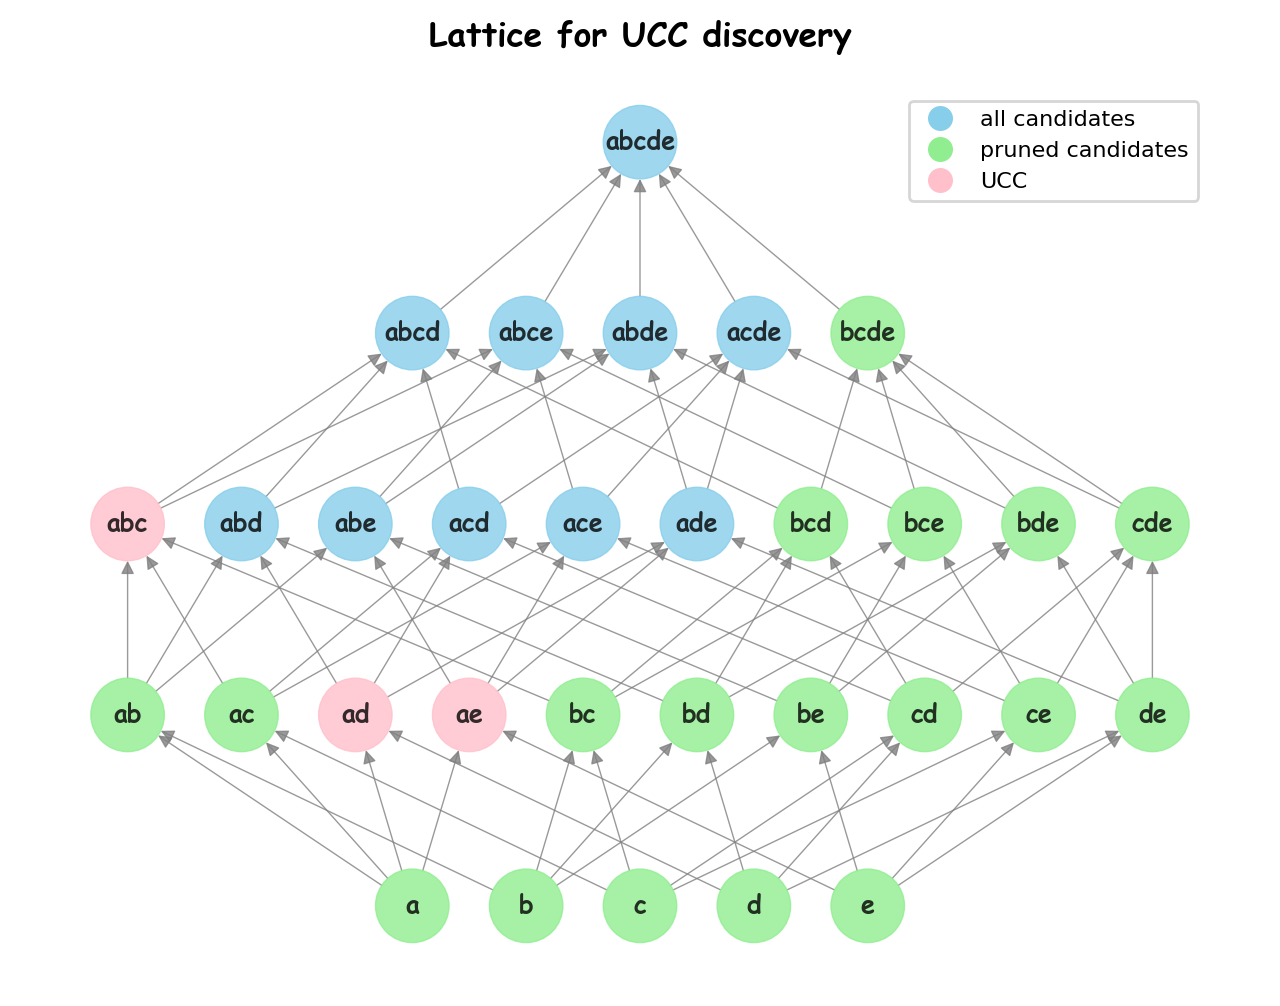

In [135]:
G = nx.DiGraph()

pos = {}
level_spacing = 2.0  # vertical spacing between levels
node_spacing = 1.0   # horizontal spacing between nodes within a level

for level, data in lattice_data.items():
    nodes = data['all']
    num_nodes = len(nodes)
    level_pos = {node: ((i - num_nodes / 2) * node_spacing, (level - 1) * level_spacing) for i, node in enumerate(nodes)}
    pos.update(level_pos)
    G.add_nodes_from(nodes)

    if level > 1:
        # connect nodes to nodes in the previous level
        prev_nodes = lattice_data[level - 1]['all']
        for node in nodes:
            for prev_node in prev_nodes:
                if set(node).issuperset(prev_node):
                    G.add_edge(prev_node, node)

node_colors = ['lightgreen' if node in lattice_data[level]['F'] else 'pink' if node in lattice_data[level]['ucc'] else 'skyblue'
               for level in lattice_data for node in lattice_data[level]['all']]

fig, ax = plt.subplots(figsize=(8, 6))

nx.draw(
    G=G, 
    pos=pos, 
    with_labels=True, 
    font_weight='bold', 
    font_family='Comic Sans MS',
    node_size=700,
    node_color=node_colors, 
    edgecolors=node_colors, # color of node boarder
    linewidths=0.5, # thickness of node boarder
    alpha=0.8, # transparency
    font_size=9, 
    arrowsize=10,
    width=0.5, # edge width
    edge_color='grey', # edge color
)

legend_labels = {
    'all candidates': 'skyblue', 
    'pruned candidates': 'lightgreen',
    'UCC': 'pink', 
}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{label}', markerfacecolor=color, markersize=10) 
                  for label, color in legend_labels.items()]

plt.legend(
    handles=legend_handles, 
    loc='lower right', 
    bbox_to_anchor=(0.95, 0.85), 
    borderaxespad=0.0,
    fontsize=8,
)
plt.title(
    label='Lattice for UCC discovery', 
    fontweight='bold', 
    fontfamily='Comic Sans MS'
)
plt.show()